Notebook pour étudier la propagation/addition des erreurs entre le RNN TPDN

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# from  GRU import GRUEncoderGD, GRUDecoderGD
# from TPDN import TensorProductEncoder

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def generate_data(batch_size, seq_len, input_size):
    '''
    input_size : pour la plage de valeur 
    '''
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles

def precision(predicted, target):
    correct = (predicted.argmax(dim=-1) == target).float()
    return correct.mean().item() * 100

def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))
    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')
    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
class GRUEncoderGD(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size, batch_first=True, num_layers=self.num_layers)


    def forward(self, sequence):
        embedded = self.embedding(sequence)  # (batch_size, seq_len, emb_size)
        output, hidden = self.rnn(embedded)  # hidden contient le dernier état caché et output la suite de tous les états cachés
        # hidden : num_layers x batchsize x emb_size
        return output, hidden

class GRUDecoderGD(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=self.num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, hidden, output_len):
        """
        hidden : Dernier état caché de l'encodeur (num_layers, batch_size, hidden_dim).
        """
        batch_size = hidden.size(1)
        outputs = []
        input_t = torch.zeros(batch_size, 1, self.hidden_size).to(self.device)  # entrée initiale
        for _ in range(output_len):
            output, hidden = self.rnn(input_t, hidden)
            output = self.out(output)  # (batch_size, 1, output_size)
            output = self.softmax(output)
            outputs.append(output.squeeze(1))  # (batch_size, output_size)
        return torch.stack(outputs, dim=1)  # (batch_size, seq_len, output_size)


In [4]:
class TensorProductEncoder(nn.Module):
    def __init__(self, n_roles, n_fillers, filler_dim, role_dim, hidden_size):
        super().__init__()

        self.n_roles = n_roles
        self.n_fillers = n_fillers
        self.filler_dim = filler_dim  # dimension des embeddings des fillers
        self.role_dim = role_dim  # dimension des embeddings des rôles

        self.hidden_size = hidden_size  # taille du vecteur caché final

        # Embedding pour les fillers et les rôles
        self.filler_embedding = nn.Embedding(self.n_fillers, self.filler_dim)
        self.role_embedding = nn.Embedding(self.n_roles, self.role_dim)

        # Couche linéaire pour adapter la sortie du produit tensoriel à la taille cachée attendue
        self.last_layer = nn.Linear(self.filler_dim * self.role_dim, self.hidden_size)

    def forward(self, filler_list, role_list):
        fillers_embedded = self.filler_embedding(filler_list)  # (batch_size, seq_len, filler_dim)
        roles_embedded = self.role_embedding(role_list)  # (batch_size, seq_len, role_dim)

        #  stocker les différentes sorties 
        batch_size = fillers_embedded.size(0)
        seq_len = fillers_embedded.size(1)
        final_states = torch.zeros(batch_size, seq_len, self.hidden_size)



        for i in range(fillers_embedded.size(1)):  # itérer sur chaque élément de la séquence
 
            fillers_expanded = fillers_embedded[:, i].unsqueeze(-1)  # (batch_size, filler_dim, 1)
            roles_expanded = roles_embedded[:, i].unsqueeze(-2)  # (batch_size, 1, role_dim)
            
            tensor_product = torch.matmul(fillers_expanded, roles_expanded)  # (batch_size, filler_dim, role_dim)
            

            tensor_product_flattened = tensor_product.view(tensor_product.size(0), -1)  # (batch_size, filler_dim * role_dim)
            

            final_state = self.last_layer(tensor_product_flattened)  # (batch_size, hidden_size)
            
     
            final_states[:, i, :] = final_state

        # final_states est maintenant une liste des états finaux pour chaque étape
        # Le dernier élément est l'état final correspondant à la séquence complète
        return final_states


In [7]:

input_size = 10
emb_size = 5
hidden_size = 32

output_size = 10
num_layers = 2
batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print( f"using {device} ")
encoder = GRUEncoderGD(input_size, emb_size, hidden_size, num_layers).to(device)
decoder = GRUDecoderGD(emb_size, hidden_size, output_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapté pour des classes discrètes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []

for epoch in range(epochs):
    data , _ = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    

    _, hidden = encoder(data)
    hidden = hidden.to(device)
    # print(hidden.shape)
    hidden = hidden[-1].unsqueeze(0).repeat(num_layers, 1, 1) 
    # on fait ca pour ne garder que la sortie de la couche finale et la copier pour avoir le bon nombre de couches pour le décodeur
    # si on met une seule couche dans le décodeur ca bug et on veut pas la suite de couches différentes sinon on peut pas l'utiliser avec le tpdn

    # print(hidden.shape)
    reconstructed_x = decoder(hidden, seq_len)#.argmax(dim=-1)

    loss = criterion(reconstructed_x.view(-1, output_size), data.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, data)
    losses.append(loss.item())
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")



torch.save(encoder, "gru_enc.pth")
torch.save(decoder, "gru_dec.pth")


fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)', color='tab:orange')  
ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title('Loss and Accuracy over Epochs')

plt.savefig(f"training_gru_{epochs}_epochs.png")
plt.show()

using cuda 
Epoch [10/10000], Loss: 2.3072, Accuracy: 11.87%
Epoch [20/10000], Loss: 2.3133, Accuracy: 8.75%
Epoch [30/10000], Loss: 2.3061, Accuracy: 12.50%
Epoch [40/10000], Loss: 2.2993, Accuracy: 13.75%
Epoch [50/10000], Loss: 2.3126, Accuracy: 4.37%
Epoch [60/10000], Loss: 2.2996, Accuracy: 8.75%
Epoch [70/10000], Loss: 2.2942, Accuracy: 13.75%
Epoch [80/10000], Loss: 2.2657, Accuracy: 11.25%
Epoch [90/10000], Loss: 2.2712, Accuracy: 13.75%
Epoch [100/10000], Loss: 2.2703, Accuracy: 18.13%
Epoch [110/10000], Loss: 2.2538, Accuracy: 13.75%
Epoch [120/10000], Loss: 2.2701, Accuracy: 9.38%
Epoch [130/10000], Loss: 2.2341, Accuracy: 11.87%
Epoch [140/10000], Loss: 2.2196, Accuracy: 14.37%
Epoch [150/10000], Loss: 2.2305, Accuracy: 15.62%
Epoch [160/10000], Loss: 2.2170, Accuracy: 16.88%
Epoch [170/10000], Loss: 2.1790, Accuracy: 20.62%
Epoch [180/10000], Loss: 2.1421, Accuracy: 15.00%
Epoch [190/10000], Loss: 2.1390, Accuracy: 18.75%
Epoch [200/10000], Loss: 2.1631, Accuracy: 15.00%
E

KeyboardInterrupt: 

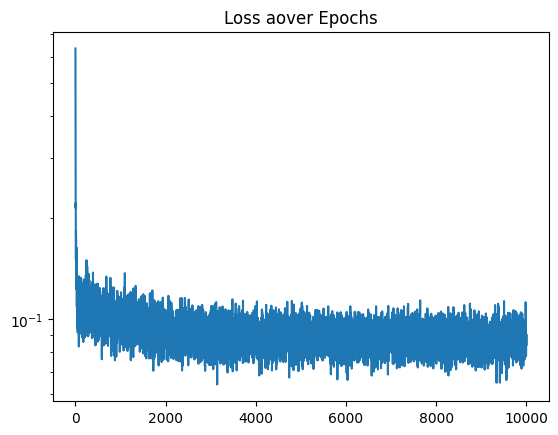

In [53]:

seq_len_tensor = torch.tensor([seq_len]).to(device)


tpdnencoder = TensorProductEncoder(n_roles=seq_len, n_fillers=seq_len, filler_dim=hidden_size, role_dim=hidden_size, hidden_size=hidden_size).to(device)
tpdnencoder.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)
epochs = 10000

encoder.eval()

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    data, roles = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    roles = roles.to(device)
    with torch.no_grad():  
        _, encoder_hidden = encoder(data)
    # _ , encoder_hidden = encoder(data)
    # print(encoder_hidden.shape)
    encoder_hidden = encoder_hidden[-1,:,:]
    # print(encoder_hidden.shape)
    tpdn_output = tpdnencoder(data, roles)[:,-1,:].to(device)
    # print(tpdn_output.shape)
    # reconstructed_x = decoder(tpdn_output.unsqueeze(0), seq_len_tensor)

    loss = criterion(tpdn_output, encoder_hidden)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

torch.save(tpdnencoder, "tpdn_gru.pth")


plt.plot(losses)
plt.yscale('log')
plt.title('Loss aover Epochs')
plt.show()



torch.Size([1, 10, 32])
torch.Size([2, 1, 32])
torch.Size([1, 32])
torch.Size([1, 10, 32])
tensor([[ 0.0928, -0.1602,  0.3635, -0.5835,  0.9988, -0.2157,  0.0715, -0.4773,
         -0.0711, -0.4365, -0.9997,  0.2011,  0.0748,  0.5272,  0.8218,  0.6880,
         -0.3531, -0.9992, -0.3880, -0.6113,  0.6654,  0.9998, -0.2235, -0.4089,
          0.6799, -0.0424,  0.3740,  0.5058, -0.7542, -0.0323,  0.3928,  0.1448]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[-0.1242,  0.2515,  0.5900, -0.5820,  1.0047, -0.2931,  0.1681, -0.3515,
         -0.0966, -0.3019, -1.0052,  0.0670,  0.1755,  0.8285,  0.7263, -0.0019,
         -0.3667, -1.0054, -0.2377, -0.2803, -0.3886,  1.0067, -0.5450, -0.4247,
         -0.2053, -0.1185,  0.4525,  0.2137,  0.1994,  0.2150,  0.4914,  0.2086]],
       grad_fn=<SliceBackward0>)


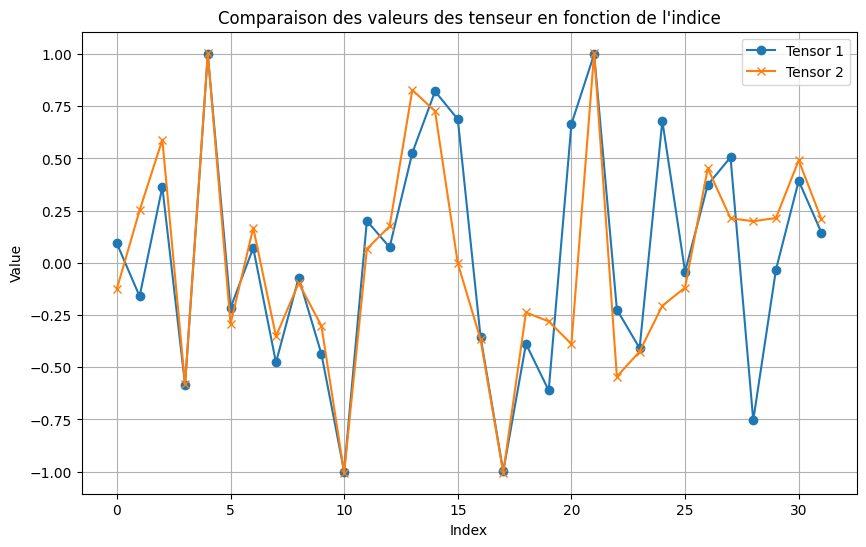

In [55]:
data , roles = generate_data(1, seq_len, input_size)
data = data.to(device)
roles = roles.to(device)
rnn_out, rnn_hidden = encoder(data)
tpdn_output= tpdnencoder(data, roles)
# tpdn_output = torch.tensor(tpdn_output)
tpdn_hidden = tpdn_output[:,-1,:]

print( rnn_out.shape)
print(rnn_hidden.shape)
print(tpdn_hidden.shape)
print(tpdn_output.shape)

print(rnn_hidden[-1])
print(tpdn_hidden)
plot_tensors(rnn_hidden[-1].cpu(), tpdn_hidden.cpu())

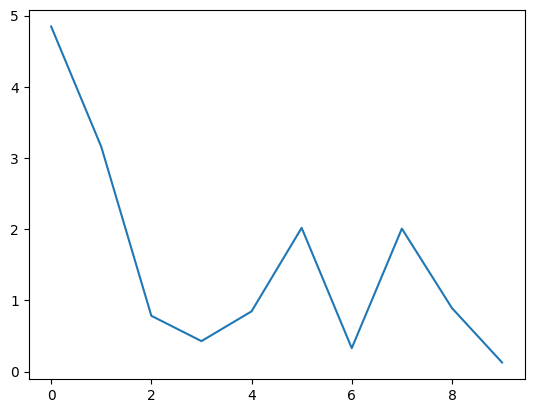

In [56]:
liste_error = []
criterion = nn.MSELoss()
for i in range(tpdn_output.shape[1]):
    liste_error.append(criterion(tpdn_output[:,i,:].cpu(), rnn_out[:,i,:].cpu()).item())

plt.plot(liste_error)